In [1]:
!pip install opencv-python
!pip install mediapipe
!pip install scikit-learn
!pip install cvzone
!pip install imutils

# 1. Importing libraries and defining dataset

In [2]:
# For capturing hand coordinates
import cv2
import cvzone
import mediapipe as mp

# For processing data
import pandas as pd
import numpy as np

#For check file
import os
import time
import webbrowser

#resize image
import imutils
import tkinter as tk
import sqlite3

In [3]:
con = sqlite3.connect('celemony.db')
cur = con.cursor()
cur.execute('''CREATE TABLE IF NOT EXISTS config
               (title text, amount INTEGER)''')
cur.execute("select * from config where title=:title", {"title": "p1ByPass"})
# check p1ByPass
data = cur.fetchall()
if len(data) == 0:
    print('init p1ByPass')
    cur.execute("insert into config values (?,?)", [("p1ByPass"),("0")])
    con.commit()
cur.execute("select * from config where title=:title", {"title": "p2ByPass"})
# check p1ByPass
data = cur.fetchall()
if len(data) == 0:
    cur.execute("insert into config values (?,?)", [("p2ByPass"),("0")])
    con.commit()
    print('init p2ByPass')

In [4]:
# dataset = pd.read_csv('./Dataset/hand_dataset_1000_24.csv')
dataset = pd.read_csv('./Dataset/hand_dataset_3000.csv')
# dataset = pd.read_csv('./Dataset/hand_dataset_MAI_3000.csv')
# dataset = pd.read_csv('./Dataset/hand_dataset_MAI_3000_space_del.csv')

# Show dataset first five data
dataset.head()

,class,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x17,y17,x18,y18,x19,y19,x20,y20,x21,y21
0,A,0.530803,0.581163,0.413990,0.501149,0.355407,0.369223,0.345517,0.263534,0.354250,...,0.534037,0.476981,0.665000,0.338577,0.605741,0.320499,0.588447,0.400885,0.594126,0.455363
1,A,0.503664,0.616673,0.377512,0.536617,0.317852,0.408111,0.306450,0.296595,0.316670,...,0.494619,0.508490,0.635405,0.349954,0.561715,0.359349,0.546541,0.440563,0.551058,0.498263
2,A,0.267808,0.670679,0.187360,0.610215,0.141140,0.503103,0.133638,0.422246,0.138989,...,0.298920,0.586336,0.368706,0.504098,0.369881,0.461587,0.362212,0.517269,0.349507,0.565708
3,A,0.289091,0.751779,0.167962,0.654705,0.100007,0.499485,0.095107,0.371244,0.122449,...,0.294725,0.624627,0.457846,0.480413,0.393687,0.455553,0.365366,0.547497,0.356335,0.612805
4,A,0.285160,0.762803,0.161197,0.667723,0.094453,0.512100,0.090644,0.383932,0.113567,...,0.292644,0.635424,0.450271,0.489606,0.388296,0.466932,0.361084,0.560643,0.352804,0.623975


In [5]:
# Show dataset overview, should return 1000 for each alphabet (excluding y and z)
dataset['class'].value_counts()

F    2883
K    2698
Y    2567
S    2563
R    2544
V    2540
G    2517
L    2509
U    2497
W    2438
D    2431
H    2406
I    2393
T    2342
E    2313
O    2282
B    2212
A    2180
X    2176
Q    2075
P    2024
C    1989
M    1675
N    1314
Name: class, dtype: int64

# 2. Creating Train and Test Data
- We use *train_test_split* since we don't really have test dataset.
- Normalizing dataset can be ignored, since we predict our data directly using raw handlandmark. 

In [6]:
# Defining X and Y from dataset for training and testing

X = dataset.iloc[:, 1:].values
Y = dataset.iloc[:, 0].values

In [7]:
from sklearn.model_selection import train_test_split

# We will take 33% from 1000 for our test data.
# Recommended value 80:20, 67:33, 50:50
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.50)

In [8]:
#Normalize / Standarize dataset

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# 3. Creating classifier model for our alphabet recognition.
- *n_neighbors* can be adjusted as we provide graph for mean errors for each *n_neighbors*

In [9]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

# 4. Calculate model accuracy

In [10]:
y_pred = classifier.predict(X_test)

In [11]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.96      0.97      0.97      1068
           B       0.98      1.00      0.99      1086
           C       0.99      1.00      0.99      1012
           D       0.99      0.98      0.99      1213
           E       0.99      0.98      0.98      1158
           F       0.98      0.99      0.99      1470
           G       0.97      1.00      0.98      1250
           H       1.00      0.97      0.98      1231
           I       0.99      0.99      0.99      1194
           K       0.94      0.97      0.95      1320
           L       0.99      0.99      0.99      1270
           M       0.92      0.90      0.91       821
           N       0.91      0.91      0.91       658
           O       0.98      0.99      0.98      1135
           P       1.00      0.98      0.99      1011
           Q       0.99      0.99      0.99      1007
           R       0.92      0.91      0.91      1286
           S       0.96    

# 5. Show graph for adjusting number of *n_neighbors*

In [12]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

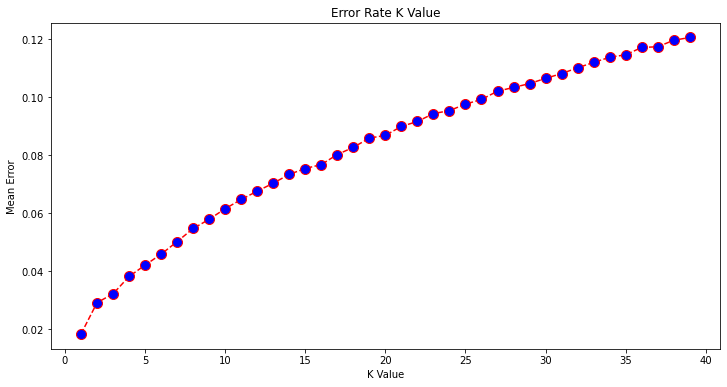

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

# 6. Intialize Mediapipe Hands for alphabet recognition.

In [14]:
# Initialize mediapipe hand

mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

# init Check Var MAI
M = False
A = False
I = False

#static var
onProcessingVideo = "./images/static/OnLoading.mp4"

#check on success
isSuccess = False

In [15]:
result = []
root = tk.Tk()
screen_width = root.winfo_screenwidth()
screen_height = root.winfo_screenheight()
window_width = screen_width/2
window_height = screen_height-30
try:
    from PIL import Image
except ImportError:
    import Image
# Count File In Folder
def countFile(Ipath):
    initial_count = 0
    for path in os.listdir(Ipath):
        if os.path.isfile(os.path.join(Ipath, path)):
            initial_count += 1
    return initial_count
# Create Function to Detect complete label "M","A","I"
def isComplete():
    if(M == True and A == True and I == True):
        return True
    else:
        return False
def checkAlpha(alph,checkOnLabel):
    global result
    result.append(alph)
    if(len(result)>=2):
        if(result[len(result)-1] == result[len(result)-2] and result[len(result)-1] == checkOnLabel):
            return True
        else:
            result.clear()
            return False
    else:
        return False
def DisplayCheckAlpha():
    global M
    global A
    global I
    result = "_|_|_"
    arr = result.split("|");
    if(M==True):
        arr[0]="M"
    if(A==True):
        arr[1]="A"
    if(I==True):
        arr[2]="I"
    print("M : "+str(M)+" A : "+str(A)+" I : "+str(I))
    return arr[0]+arr[1]+arr[2]
# Write detect file
def writeFile(iAlpha,img):
    BasePath = "./archive/ceremony/"+iAlpha
    isExist = os.path.exists(BasePath)
    if not isExist:
        os.makedirs(BasePath)
    cv2.imwrite(os.path.join(BasePath, f'{countFile(BasePath):04d}' +'.jpg'), img)
def __draw_label(img, text, pos, bg_color,text_color=(0, 0, 0)):
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    scale = 5
    color = text_color
    thickness = cv2.FILLED
    margin = 2

    txt_size = cv2.getTextSize(text, font_face, scale, thickness)

    end_x = pos[0] + txt_size[0][0] + margin
    end_y = pos[1] - txt_size[0][1] - margin-20

    cv2.rectangle(img, (pos[0],pos[1]+20), (end_x, end_y), bg_color, thickness)
    cv2.putText(img, text, pos, font_face, scale, color, 10, cv2.LINE_AA)
def rescale_frame(frame):
    global screen_width,screen_height,window_width,window_height
    frame_width = int(frame.shape[1])
    frame_height = int(frame.shape[0])
    #crop image
    crop_width = (frame_height/window_height)*window_width
    crop_height = frame_height
    x1 = (frame_width/2)-(crop_width/2)
    x2 = (frame_width/2)+(crop_width/2)
    frame_croped = frame[0:int(frame_height), int(x1):int(x2)]
    #resize image
    dim = (int(window_width), int(window_height))
    return cv2.resize(frame_croped, dim, interpolation =cv2.INTER_AREA)
def startXPosition(index):
    xList = [0,0,0]
    root = tk.Tk()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    for i in range(len(xList)):
        if(i > 0):
            xList[i] = xList[i-1]+int(screen_width/2)
    return xList[index]
def playOnProcessingVideo(webcamFrame,cap_vid,esmateTime,time_passed):
    global onProcessingVideo
    #return webcamFrame
    if esmateTime>0:
        # Video feed
        ret, frame_vid = cap_vid.read()
        if not ret:
            print('Cannot open video stream: ' + filename)
            cap_vid.release()
            exit()
        ret = cap_vid.set(cv2.CAP_PROP_POS_MSEC, time_passed)
        if not ret:
            print('An error occured while setting video time')
            exit()
        # Rescale 
        frame_vid = rescale_frame(frame_vid)
        # Blend the two images and show the result
        tr = 0.5 # transparency between 0-1, show camera if 0 
        frame = ((1-tr) * webcamFrame.astype(np.float64) + tr * frame_vid.astype(np.float64)).astype(np.uint8)
        return frame
    else:
        return webcamFrame

In [16]:
currentProjectLabel = "I"
alphabetHand = cv2.imread('./images/static/'+currentProjectLabel+'_Hand_final.png', cv2.IMREAD_UNCHANGED)
alphabetImage = cv2.imread('./images/static/Aplha_'+currentProjectLabel+'.png', cv2.IMREAD_UNCHANGED)
alphabetImage = cv2.resize(alphabetImage,(0,0),None,0.5,0.5)
alphabetHand = cv2.resize(alphabetHand,(0,0),None,0.25,0.25)
passImage = cv2.imread('./images/static/checked.png', cv2.IMREAD_UNCHANGED)
passImage = cv2.resize(passImage,(0,0),None,0.15,0.15)

In [68]:
def DetectionAlpha(currentProjectLabel,videoRecorderIndex,windowpositionX,windowpositionY):
    try:
        con = sqlite3.connect('celemony.db')
        cur = con.cursor()
        processName_ByPass = "p"+str((videoRecorderIndex+1))+"ByPass"
        processName_Status = "p"+str((videoRecorderIndex+1))+"Status"
        cur.execute("update config set amount=1 where title='"+processName_Status+"'")
        con.commit()
        cap = cv2.VideoCapture(videoRecorderIndex)
        success,img = cap.read()
        isStartCheck = False
        enableByPass = False
        byPass = False
        global alphabetHand,alphabetImage,passImage
        global isSuccess
        checkedImg = passImage
        overlay = alphabetHand
        hf,wh,cf = overlay.shape
        hc,wc,cc = alphabetImage.shape
        hp,wp,cp = checkedImg.shape
        captureImg = img
        prepareWin = "Hand Tracking - "+currentProjectLabel
        displayResultWindowName = "Display Result - "+currentProjectLabel
        isComplete = False
        #video on Processing 
        filename = onProcessingVideo
        cap_vid = cv2.VideoCapture(filename)
        with mp_hands.Hands(
            max_num_hands = 1,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5) as hands:
            start_time = time.time()
            DELAY_SECONDS = 1
            t1 = time.time()
            while cap.isOpened():
                cur.execute("select * from config where title='"+processName_ByPass+"'")
                data = cur.fetchall()
                if len(data) > 0:
                    if data[0][1] == 1:
                        byPass = True
                    else:
                        byPass = False
                success, image = cap.read()
                # resize image
                image = rescale_frame(image)
                hb,wb,cb = image.shape
                if not success:
                    print("Ignoring empty camera frame.")
                    # If loading a video, use 'break' instead of 'continue'.
                    continue
                # Flip the image horizontally for a later selfie-view display, and convert
                # the BGR image to RGB.
                #image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # To improve performance, optionally mark the image as not writeable to
                # pass by reference.
                image.flags.writeable = False
                results = hands.process(image)

                # Draw the hand annotations on the image.
                image.flags.writeable = True
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

                # Draw Alphabet and Hand
    #             __draw_label(image, currentProjectLabel, (wb-100,150), (255,255,255))
                image = cvzone.overlayPNG(image,overlay,[0,0])
                #image = cvzone.overlayPNG(image,alphabetImage,[wb-hc,0])
                # Get status box
                #cv2.rectangle(image, (0,hb-80), (200, hb), (245, 90, 16), -1)
                cv2.rectangle(image, (wb-250,250), (wb, 0), (255, 255, 255), -1)
#                 textsize = cv2.getTextSize("A", fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=10, thickness=15)
#                 #print(textsize[0][0])
#                 x = wb-240+((int(textsize[0][0]))/2);
#                 #print(x)
#                 x = 835-((int(textsize[0][0]))/2);
#                 print(x)
#                 cv2.putText(image, "A"
#                                     ,(int(x),220) , cv2.FONT_HERSHEY_SIMPLEX, 10, (0, 0, 0), 15, cv2.LINE_AA)
        #         cv2.putText(image, DisplayCheckAlpha(), (20,25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                # Display Class
                isSameAlpha = False
                key = cv2.waitKey(1)
                if not results.multi_hand_world_landmarks:
                    t1 = time.time()
                    isStartCheck = False
                if(byPass == True):
                    cv2.putText(image, "*"
                                    , (wb-30,hb-30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)
                if results.multi_hand_landmarks:
                    for hand_landmarks in results.multi_hand_landmarks:
                        coords = hand_landmarks.landmark
                        mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                        coords = list(np.array([[landmark.x, landmark.y] for landmark in coords]).flatten())
        #                 coords = list(np.array([[landmark.x, landmark.y, landmark.z] for landmark in coords]).flatten())
                        coords = scaler.transform([coords])

                        # Alternative for dataset using z coordinates.
                        # Z coordinates is not recommended, since you need to adjust your distance from camera.


                        predicted = classifier.predict(coords)
                    if(byPass == False):
                        textsize = cv2.getTextSize(str(predicted[0]), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=10, thickness=15)
                        x = 835-((int(textsize[0][0]))/2);
                        cv2.putText(image, str(predicted[0])
                                    ,(int(x),220) , cv2.FONT_HERSHEY_SIMPLEX, 10, (0, 0, 0), 15, cv2.LINE_AA)

                        if(len(predicted) > 0):
                            isSameAlpha = checkAlpha(predicted[0],currentProjectLabel)
                            if(isSameAlpha == True and isStartCheck == False):
                                t1 = time.time()
                                isStartCheck = True
                            if(isSameAlpha == True and isStartCheck == True):
                                duration = time.time()-t1
                                esmateTime = (DELAY_SECONDS - duration)
                                if(esmateTime < 0):
                                    esmateTime = 0
                                cv2.putText(image, format(esmateTime, '.0f')
                                    , (wb-40,hb-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)
                                # insert video in waiting delay time
                                image = playOnProcessingVideo(image,cap_vid,esmateTime,duration*1000)
                                if(duration >=DELAY_SECONDS and isSuccess == False):
                                    print("Checked")
                                    t1 = time.time()
                                    isStartCheck = False
                                    # Capture image and Display
                                    writeFile(currentProjectLabel,image)
                                    captureImg = image
                                    isComplete = True
                                    # __draw_label(captureImg, currentProjectLabel, (wb-100,150), (0,128,0),(255, 255, 255))
                                    #captureImg = cvzone.overlayPNG(captureImg,checkedImg,[int(wb/2)-int(wp/2),hb-hp-20])
                                    #captureImg = cvzone.overlayPNG(captureImg,checkedImg,[0,0])

                                    cv2.imshow(displayResultWindowName, captureImg)
                                    # Move window to position
                                    cv2.moveWindow(displayResultWindowName,windowpositionX,windowpositionY)
                                    isSuccess = True
                                    cur.execute("update config set amount=2 where title='"+processName_Status+"'")
                                    con.commit()
                            #Reset when not same
                            if(isSameAlpha == False and isStartCheck == True):
                                t1 = time.time()
                                isStartCheck = False
                    else:
                        textsize = cv2.getTextSize(str(currentProjectLabel), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=10, thickness=15)
                        x = 835-((int(textsize[0][0]))/2);
                        cv2.putText(image, str(currentProjectLabel)
                                    ,(int(x),220) , cv2.FONT_HERSHEY_SIMPLEX, 10, (0, 0, 0), 15, cv2.LINE_AA)
                        isSameAlpha = checkAlpha(currentProjectLabel,currentProjectLabel)
                        if(isStartCheck == False):
                            t1 = time.time()
                            isStartCheck = True
                            # print('Start Time : '+str(t1))
                        if(isStartCheck == True):
                            curTime = time.time()
                            duration = curTime -t1
                            # print('Current Time : '+str(curTime))
                            # print('duration : '+str(duration))
                            esmateTime = (DELAY_SECONDS - duration)
                            if(esmateTime < 0):
                                esmateTime = 0
                            cv2.putText(image, format(esmateTime, '.0f')
                                , (wb-40,hb-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)
                            # insert video in waiting delay time
                            image = playOnProcessingVideo(image,cap_vid,esmateTime,duration*1000)
                            if(duration >=DELAY_SECONDS):
                                print("Checked")
                                t1 = time.time()
                                isStartCheck = False
                                # Capture image and Display
                                writeFile(currentProjectLabel,image)
                                captureImg = image
                                isComplete = True
                                # __draw_label(captureImg, currentProjectLabel, (wb-100,150), (0,128,0),(255, 255, 255))
                                #captureImg = cvzone.overlayPNG(captureImg,checkedImg,[int(wb/2)-50,hb-hc-20])

                                cv2.imshow(displayResultWindowName, captureImg)
                                # Move window to position
                                cv2.moveWindow(displayResultWindowName,windowpositionX,windowpositionY)
                                isSuccess = True
                                byPass = False
                                cur.execute("update config set amount=0 where title='"+processName_ByPass+"'")
                                con.commit()
                                cur.execute("update config set amount=2 where title='"+processName_Status+"'")
                                con.commit()
                try:
                    cv2.imshow(prepareWin, image)
                    # Move window to position
                    cv2.moveWindow(prepareWin,windowpositionX,windowpositionY)
                except:
                    print("Error on Creating Capture")
                # Check Reset
                cur.execute("select * from config where title='"+processName_Status+"'")
                data = cur.fetchall()
                if len(data) > 0:
                    if data[0][1] == -1:
                        cv2.destroyWindow(displayResultWindowName)
                        isSuccess = False
                        print(displayResultWindowName + " is closed")
                key = cv2.waitKey(5)
                if key & 0xFF == ord(currentProjectLabel.lower()):
                    try:
                        cv2.destroyWindow(displayResultWindowName)
                        isSuccess = False
                        print(displayResultWindowName + " is closed")
                    except:
                        print(displayResultWindowName + " is not opened")
                # when closed result
                if(cv2.getWindowProperty(prepareWin,cv2.WND_PROP_VISIBLE)==1 and cv2.getWindowProperty(displayResultWindowName,cv2.WND_PROP_VISIBLE)==0):
                    isSuccess = False
                    cur.execute("update config set amount=1 where title='"+processName_Status+"'")
                    con.commit()
                # wait multiple key
                pressedKey = cv2.waitKey(5) & 0xFF
                if pressedKey == ord(str(videoRecorderIndex+1)):
                    if enableByPass == True:
                        byPass = True
                        cur.execute("update config set amount=1 where title='"+processName_ByPass+"'")
                        con.commit()
                        print('Bypass was running')
                    else:
                        print('Bypass has Disable')
                elif pressedKey == ord('p'):
                    enableByPass = True
                    print('Bypass has Enable')
                # on press esc to quit
                if cv2.waitKey(5) & 0xFF == 27:
                    break
        cap.release()
        cv2.destroyAllWindows()
        cur.execute("update config set amount=0 where title='"+processName_Status+"'")
        con.commit()
        con.close()
    except Exception as er:
        print("Error :",er)    

In [ ]:
# Start Detection function
global currentProjectLabel
print(currentProjectLabel)
DetectionAlpha(currentProjectLabel,1,startXPosition(1),0)

I
Checked
Display Result - I is closed
Checked
Display Result - I is closed
Checked
Display Result - I is closed
Checked
Display Result - I is closed
Checked
Display Result - I is closed
Checked
Display Result - I is closed
Checked
Display Result - I is closed
Checked
Display Result - I is closed
